In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import random
import os
import scipy.io as sio
import scipy
import json
from numpy.ma.core import sqrt
import skimage.io as skio
from skimage.measure import label, regionprops, regionprops_table
from skimage.measure import find_contours
from skimage.color import rgba2rgb
from tqdm import tqdm
import skimage.measure as measure
import graph_tool.all as gt
import skimage.transform as transform
from skimage.util import img_as_ubyte
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.cm as cm

In [4]:
import openslide

## Get coordinates


In [7]:
def load_json(folder, wsi_basename):
    # load the json file (may take ~20 secs)
    json_path_wsi = './{}/json/'.format(folder) + wsi_basename + '.json'

    bbox_list_wsi = []
    centroid_list_wsi = []
    contour_list_wsi = [] 
    type_list_wsi = []

    # add results to individual lists
    with open(json_path_wsi) as json_file:
        data = json.load(json_file)
        mag_info = data['mag']
        nuc_info = data['nuc']
        for inst in nuc_info:
            inst_info = nuc_info[inst]
            inst_centroid = inst_info['centroid']
            centroid_list_wsi.append(inst_centroid)
            inst_contour = inst_info['contour']
            contour_list_wsi.append(inst_contour)
            inst_bbox = inst_info['bbox']
            bbox_list_wsi.append(inst_bbox)
            inst_type = inst_info['type']
            type_list_wsi.append(inst_type)
            
    return centroid_list_wsi, contour_list_wsi, bbox_list_wsi, type_list_wsi

15_26609_024_045 L02 HE
total cells 2774 lymphocytes 405
((95232, 39168), (47616, 19584), (23808, 9792), (11904, 4896), (5952, 2448), (2976, 1224), (1488, 612), (744, 306), (372, 153))


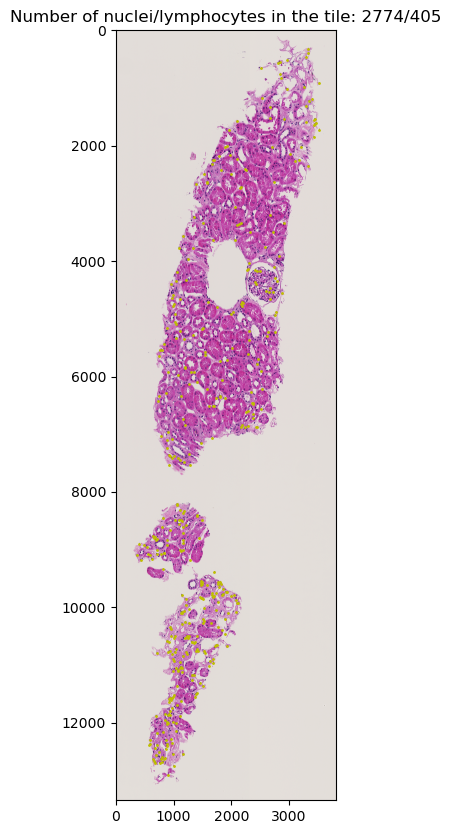

In [15]:
# crop roi
folder = 'MCD'
cases = os.listdir('./{}/mask'.format(folder))
cases = [case[:-4] for case in cases]
for wsi_basename in cases:
    if 'crop' in wsi_basename:
        continue
    print(wsi_basename)
    msk = skio.imread('./{}/mask/{}.png'.format(folder, wsi_basename))
    img = skio.imread('./{}/thumb/{}.png'.format(folder, wsi_basename))
    msk = msk[:,:]/255
    msk = msk.astype(np.uint8)
    labeled = measure.label(msk)
    regions = measure.regionprops(labeled)
    # find bounding boxes for each region
    bboxes = []
    for region in regions:
        bboxes.append(region.bbox)
    bboxes = np.array(bboxes)
    # find the merged bounding box for all regions
    bbox = np.array([np.min(bboxes[:,0]), np.min(bboxes[:,1]), np.max(bboxes[:,2]), np.max(bboxes[:,3])])
    msk_crop = msk[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    img_crop = img[bbox[0]:bbox[2], bbox[1]:bbox[3], :]
    # save the cropped mask
    skio.imsave('./{}/mask/{}_crop.png'.format(folder, wsi_basename), msk_crop*255)

    # load json file
    centroid_list_wsi, contour_list_wsi, bbox_list_wsi, type_list_wsi = load_json(folder, wsi_basename)
    # modify json to the cropped region
    # define the region in original wsi axis level 0
    x_tile = bbox[1]*32
    y_tile = bbox[0]*32
    w_tile = (bbox[3] - bbox[1])*32
    h_tile = (bbox[2] - bbox[0])*32
    coords_xmin = x_tile
    coords_xmax = x_tile + w_tile
    coords_ymin = y_tile
    coords_ymax = y_tile + h_tile
    
    # modify the json file
    # collect cells in the region
    tile_info_dict = {}
    count_tol = 0
    count_lym = 0

    for idx, cnt in enumerate(contour_list_wsi):
        cnt_tmp = np.array(cnt)
        cnt_tmp = cnt_tmp[(cnt_tmp[:,0] >= coords_xmin) & (cnt_tmp[:,0] <= coords_xmax) & (cnt_tmp[:,1] >= coords_ymin) & (cnt_tmp[:,1] <= coords_ymax)] 
        label = str(type_list_wsi[idx])
        if cnt_tmp.shape[0] > 0:
            cnt_adj = np.round(cnt_tmp - np.array([x_tile,y_tile])).astype('int')
            inst_centroid = centroid_list_wsi[idx]
            inst_centroid = np.round(inst_centroid - np.array([x_tile,y_tile])).astype('int')
            tile_info_dict[idx] = {'contour': cnt_adj.tolist(), 'centroid': inst_centroid.tolist(), 'type':label}
            count_tol += 1
            # count predicted lymphocytes
            if label == '2':
                count_lym += 1

    print('total cells', count_tol, 'lymphocytes', count_lym)

    # plot cells in the cropped region
    # resize the image to 32x using skimage
    # img_crop = transform.resize(img_crop, (h_tile, w_tile), anti_aliasing=True)
    # load the wsi object and read/save region
    obj = openslide.OpenSlide('../hover_net/data_MCD/15_26609_024_045 L02 HE.ndpi')
    # print levels
    print(obj.level_dimensions)
    wsi_tile = obj.read_region((x_tile, y_tile), 0, (w_tile,h_tile))
    wsi_tile = rgba2rgb(np.array(wsi_tile))
    # as uint8
    wsi_tile = img_as_ubyte(wsi_tile)
    # save the image
    skio.imsave('./{}/thumb/{}_crop.png'.format(folder, wsi_basename), wsi_tile)
    plt.figure(figsize=(10,10))
    plt.imshow(wsi_tile)
    for idx in tile_info_dict:
        inst_info = tile_info_dict[idx]
        inst_centroid = inst_info['centroid']
        inst_type = inst_info['type']
        if inst_type == '2':
            plt.scatter(inst_centroid[0], inst_centroid[1], c='y',s=1)
              
    plt.title('Number of nuclei/lymphocytes in the tile: {}/{}'.format(count_tol, count_lym))
    plt.savefig('./{}/overlay/{}.png'.format(folder, wsi_basename), dpi=300)


    # save the modified json file
    with open('./{}/json/{}_crop.json'.format(folder,wsi_basename), 'w') as fp:
        json.dump(tile_info_dict, fp)


## get graph and community

In [18]:
folder = 'MCD'
cases = os.listdir('./{}/overlay'.format(folder))
cases = [case[:-4] for case in cases]
for wsi_basename in cases:
    print(wsi_basename)
    f = open('./{}/json/{}_crop.json'.format(folder, wsi_basename))
    tile_info_dict = json.load(f)
    # create a graph from the centroids of lymphocytes
    points = []
    for idx in tile_info_dict:
        inst_info = tile_info_dict[idx]
        inst_centroid = inst_info['centroid']
        inst_type = inst_info['type']
        if inst_type == '2':
            x0, y0 = inst_centroid[0], inst_centroid[1]
            points.append([x0,y0])
    points = np.array(points)
    # set the connect distance
    connect = 100
    # create graph
    g, pos = gt.geometric_graph(points[:], connect)
    g.set_directed(False)
    # add vertex properties
    g.vertex_properties["pos"] = pos
    # save graph
    g.save("./{}/json/graph_{}.gt".format(folder, wsi_basename))
    gt.graph_draw(g, pos=g.vp['pos'], vprops = {"fill_color" : 'yellow', "size" : 1}, eprops = {"pen_width" : 1, "color":'yellow'} , bg_color='black', output = "./{}/graph/{}_{}.png".format(folder, wsi_basename, connect) , fmt = 'png')

    # load graph
    g = gt.load_graph("./{}/json/graph_{}.gt".format(folder, wsi_basename))
    # community decomposition using modularity
    state = gt.minimize_nested_blockmodel_dl(g)
    # list all levels of the decomposition
    levels = state.get_levels()
    state.print_summary()
    # save the partition at each level (using the first 4 levels here)
    prop_1 = state.project_partition(0,0)
    g.vp["label0"] = prop_1
    prop_1 = state.project_partition(1,0)
    g.vp["label1"] = prop_1
    prop_1 = state.project_partition(2,0)
    g.vp["label2"] = prop_1
    prop_1 = state.project_partition(3,0)
    g.vp["label3"] = prop_1
    # save the graph again with the partition
    g.save("./{}/json/graph_{}.gt".format(folder, wsi_basename))
    # draw the graph with the partition
    prop_1 = g.vp["label0"] 
    gt.graph_draw(g, pos=g.vp["pos"], vertex_fill_color= prop_1, vertex_text=prop_1, output="./{}/graph/{}_communityL0.png".format(folder, wsi_basename))
    prop_1 = g.vp["label1"] 
    gt.graph_draw(g, pos=g.vp["pos"], vertex_fill_color= prop_1, vertex_text=prop_1, output="./{}/graph/{}_communityL1.png".format(folder, wsi_basename))
    prop_1 = g.vp["label2"] 
    gt.graph_draw(g, pos=g.vp["pos"], vertex_fill_color= prop_1, vertex_text=prop_1, output="./{}/graph/{}_communityL2.png".format(folder, wsi_basename))
    prop_1 = g.vp["label3"] 
    gt.graph_draw(g, pos=g.vp["pos"], vertex_fill_color= prop_1, vertex_text=prop_1, output="./{}/graph/{}_communityL3.png".format(folder, wsi_basename))


15_26609_024_045 L02 HE
l: 0, N: 405, B: 10
l: 1, N: 10, B: 5
l: 2, N: 5, B: 2
l: 3, N: 2, B: 1
l: 4, N: 1, B: 1


## get graph features

In [19]:
def get_feature(sg, df, ind): 
    # chack if the graph has edge
    weight = sg.new_edge_property("double")
    for e in sg.edges():
        weight[e] = np.linalg.norm(sg.vp["pos"][e.target()].a - sg.vp["pos"][e.source()].a)
    sg.edge_properties["weight"] = weight
    # feature - clustering coefficieo
    clus, dev_clus= gt.global_clustering(sg) # weight
    # feature - average shortest path length
    dist_list = []
    for v in sg.vertices():
        dist = gt.shortest_distance(sg, source=v,  weights=sg.ep.weight)
        dist_list.append(np.max(dist.a[~np.isinf(dist.a)]))
    avg_dist = np.mean(dist_list)
    # feature - diameter
    diameter = np.max(dist_list)
    # feature - average degree
    avg_degree = np.mean(sg.get_total_degrees(sg.get_vertices()))
    # feature - number of nodes
    num_nodes = sg.num_vertices()
    # feature - kcore 
    kcore = gt.kcore_decomposition(sg)
    max_kcore = np.max(kcore.a)
    mean_kcore = np.mean(kcore.a)
    num_kcore = np.sum(kcore.a == max_kcore)
    # feature - correlation
    corr_mean, corr_var = gt.assortativity(sg, 'total')  # eweight
    # betweenness centrality
    vb, eb = gt.betweenness(sg) # weight
    # feature - average betweenness centrality
    avg_betweenness = np.mean(vb.a)
    # feature - number of nodes with high betweenness centrality
    num_high_betweenness = np.sum(vb.a > np.mean(vb.a))/sg.num_vertices()
    # feature - central node
    cd = gt.central_point_dominance(sg, vb)
    # eigrn vector centrality
    ee, x = gt.eigenvector(sg)
    # add to dataframe
    new = {"community_id": ind,'clus':clus, 'clus_dev':dev_clus, 'avg_dist':avg_dist, 'diameter':diameter, 'avg_degree':avg_degree, 'num_nodes':np.array(num_nodes).max(), 'max_kcore':np.array(max_kcore).max(), 'mean_kcore':np.array(mean_kcore).max(), 'num_kcore':np.array(num_kcore).max(), 'corr_mean':corr_mean,'corr_var':corr_var, 'avg_betweenness':np.array(avg_betweenness).max(), 'num_high_betweenness':np.array(num_high_betweenness).max(), 'central_node_dom':cd, 'eigenvector_centrality':ee}
    #df = df.append({"community_id": ind,'clus':clus, 'clus_dev':dev_clus, 'avg_dist':avg_dist, 'diameter':diameter, 'avg_degree':avg_degree, 'num_nodes':np.array(num_nodes).max(), 'max_kcore':np.array(max_kcore).max(), 'mean_kcore':np.array(mean_kcore).max(), 'num_kcore':np.array(num_kcore).max(), 'corr_mean':corr_mean,'corr_var':corr_var, 'avg_betweenness':np.array(avg_betweenness).max(), 'num_high_betweenness':np.array(num_high_betweenness).max(), 'central_node_dom':cd, 'eigenvector_centrality':ee}, ignore_index=True)
    df = pd.concat([df, pd.DataFrame(new,index=[0])], ignore_index=True)
    return df

# compute community features in each slide
folder = 'MCD'
cases = os.listdir('./{}/overlay'.format(folder))
cases = [case[:-4] for case in cases]
for wsi_basename in cases: 
    # create a dataframe to store features 
    df = pd.DataFrame(columns=['community_id','clus','clus_dev', 'avg_dist', 'diameter', 'avg_degree', 'num_nodes', 'max_kcore', 'mean_kcore', 'num_kcore', 'corr_mean','corr_var', 'avg_betweenness', 'num_high_betweenness', 'central_node_dom', 'eigenvector_centrality'])  
    g = gt.load_graph("./{}/json/graph_{}.gt".format(folder, wsi_basename))  
    # get the community label at level 1
    level = 1
    prop_1 = g.vp["label{}".format(level)]
    # get all the unique community labels
    uni, cnt = np.unique(prop_1.a, return_counts=True) 
    # get features for each community (subgraph)
    for i in range(0, len(uni)):
        # sg is the subgraph with only nodes in community i
        sg = gt.GraphView(g, vfilt=lambda v: prop_1[v] == uni[i])
        # add graph features from this subgraph to dataframe
        df = get_feature(sg, df, uni[i])
    # save dataframe
    df.to_csv("./{}/feature/{}_communityL{}.csv".format(folder, wsi_basename, level), index=False)




 #### what if no features?
 #### scale feature at slide level or all cases? 

In [24]:
# bin communities in a slide into 2 clusters based on the features
folder = 'MCD'
level = 1
cases = os.listdir('./{}/feature'.format(folder))
for case in cases:
    wsi_basename = case[:-16]
    print(wsi_basename)
    df = pd.read_csv("./{}/feature/{}".format(folder, case))
    # cluster into 2 groups based on the features
    df = df.fillna(0)
    # normalize the features
    X = df[df.columns[1:]].values
    x_scaled = preprocessing.normalize(X, axis=0)
    # weight the feature importance
    x_scaled[:,2] = x_scaled[:,2]*3
    # cluster
    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(x_scaled)
    df['cluster_label'] = kmeans.labels_
    df[df.columns[1:-1]] = x_scaled
    # save the dataframe
    df.to_csv("./{}/feature/{}_normalize.csv".format(folder, wsi_basename), index=False)

    # assign new cluster labels to graphs and visualize
    # create a new vertex property with the cluster label
    g = gt.load_graph("./{}/json/graph_{}.gt".format(folder, wsi_basename))  
    cluster_label = g.new_vertex_property("int")
    # get the community label for each vertex at level1
    community_label = g.vp["label{}".format(level)].a
    cluster_label_a = []
    # assign the cluster label to each vertex
    for i in community_label:
        # df['cluster_label'] is df.columns[-1]
        cluster_label_a.append(df[df.community_id == i][df.columns[-1]].values[0])
    cluster_label.a = cluster_label_a
    g.vp["cluster_label{}".format(level)] = cluster_label

    # draw the graph with the vertex color set to the "cluster" property
    gt.graph_draw(g, pos=g.vp["pos"], vertex_fill_color= cluster_label, vertex_text=cluster_label, vcmap=cm.gist_rainbow, output="./{}/graph/{}_communityL{}_cluster2.png".format(folder, wsi_basename, level))
    # save graph
    g.save("./{}/json/graph_{}.gt".format(folder, wsi_basename))

15_26609_024_045 L02 HE
